In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clip

import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [47]:
cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fontsize = 40
labelsize = 30

color_bl = '#648FFF' #blue
color_id = '#785EF0' #indigo
color_mg = '#DC267F' #magenta
color_or = '#FE6100' #orange

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=2.725)

### Let's do it first to the mock

In [290]:
x_cluster_r = np.loadtxt("cluster-mock-R/xa.txt")
y_cluster_r = np.loadtxt("cluster-mock-R/ya.txt")
z_cluster_r = np.loadtxt("cluster-mock-R/za.txt")
mag_cluster_r = np.loadtxt( "cluster-mock-R/mag_cluster.txt")

xcampo_r = np.loadtxt("cluster-mock-R/xcampo.txt")
ycampo_r = np.loadtxt("cluster-mock-R/ycampo.txt")
zcampo_r = np.loadtxt("cluster-mock-R/zcampo.txt")
mag_campo_r = np.loadtxt("cluster-mock-R/mag_campo.txt")

ra = np.concatenate((xcampo_r, x_cluster_r))
dec = np.concatenate((ycampo_r, y_cluster_r))
zml = np.concatenate((zcampo_r, z_cluster_r))
rpetro = np.concatenate((mag_campo_r, mag_cluster_r))

In [432]:
#Defining values for the cluster mock

Ragl = 5 #in "degrees". This is the value we set for the cluster radius in the mock
sigma_z = 0.012 #I think this has to be a function of magnitude (use sigma_nmad(r))
zagl = 0.01

ra0 = 0.0
dec0 = 0.0

#### In the paper, they compute a function $n_F$ for the background number density of galaxies as a function of magnitude and redshift
#### But, for now, we are not going to consider any dependence on magnitude or redshift

We do that by computing the number of galaxies per redshift bin ($\Delta z = 0.05)$ and magnitude bins ($\Delta m = 0.8$). First, we have to get rid of galaxies inside a certain radius and a certain range of redshifts, in order to avoid the risk of getting galaxies that are group members. We can choose for example to exclude the volume within $5 R_{200,c}$ and $z_G \pm 5 \sigma_{\mathcal{P}}(\bar{m})$. My ideia is to make a function (of redshift) for each magnitude bin. The function can be generated for example by fitting a linear function over the distribution of $n_F(z)$. Afterwards, we will have to extrapolate this function to lower values of redshift, to account for the redshifts we excluded earlier.

In [69]:
dm = 0.5
dz = 0.01

nF_m_z = []

for m in np.arange(13.5, 20.5, dm):
    for z in np.arange(0.0, 0.21, dz):
        mask = (rpetro > m) & (rpetro < m + dm) & (zml > z) & (zml < z + dz)
        nF_m_z.append([m, z, np.sum(mask)])

# nF_m_z = np.array(nF_m_z)
nF_m_z = pd.DataFrame(nF_m_z, columns = ['m','z','n'])

m
13.5    AxesSubplot(0.125,0.125;0.775x0.755)
14.0    AxesSubplot(0.125,0.125;0.775x0.755)
14.5    AxesSubplot(0.125,0.125;0.775x0.755)
15.0    AxesSubplot(0.125,0.125;0.775x0.755)
15.5    AxesSubplot(0.125,0.125;0.775x0.755)
16.0    AxesSubplot(0.125,0.125;0.775x0.755)
16.5    AxesSubplot(0.125,0.125;0.775x0.755)
17.0    AxesSubplot(0.125,0.125;0.775x0.755)
17.5    AxesSubplot(0.125,0.125;0.775x0.755)
18.0    AxesSubplot(0.125,0.125;0.775x0.755)
18.5    AxesSubplot(0.125,0.125;0.775x0.755)
19.0    AxesSubplot(0.125,0.125;0.775x0.755)
19.5    AxesSubplot(0.125,0.125;0.775x0.755)
20.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

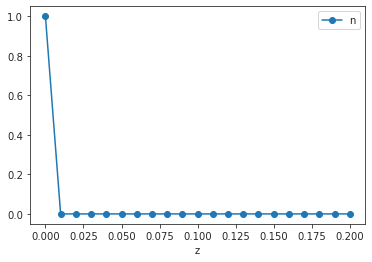

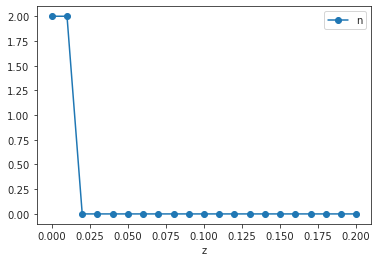

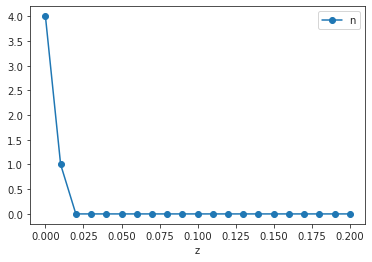

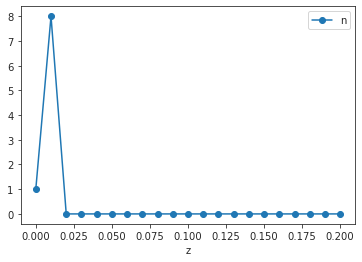

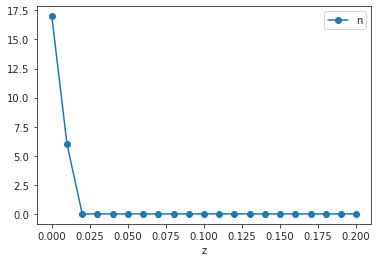

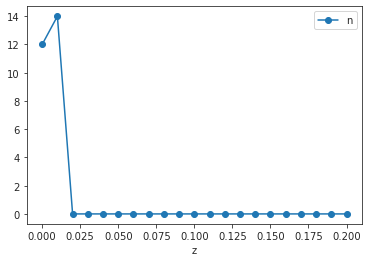

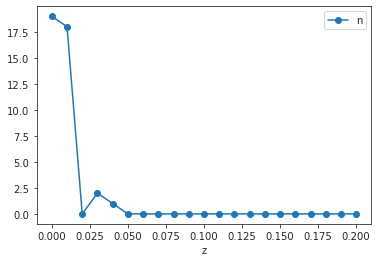

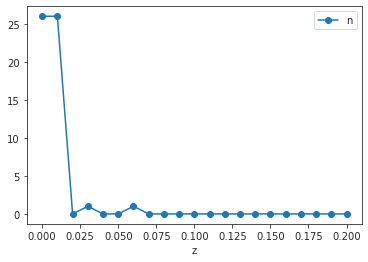

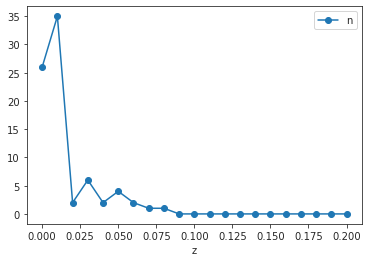

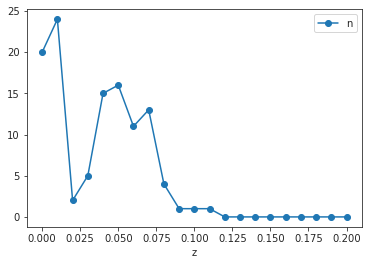

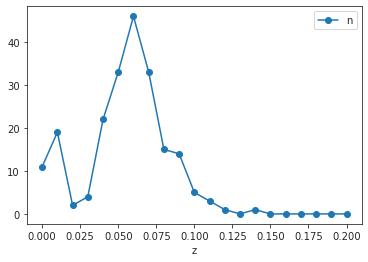

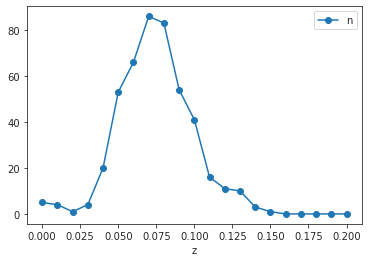

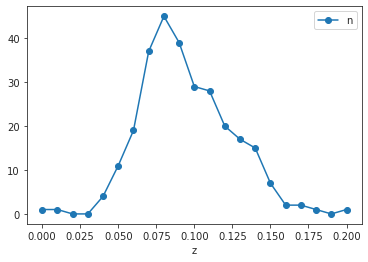

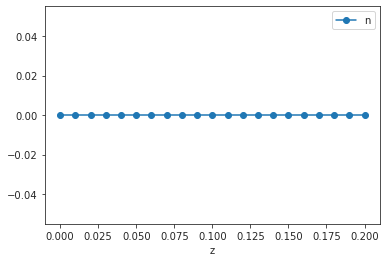

In [70]:
nF_m_z.groupby(by=["m"]).plot(x='z', y='n', marker='o')

#### Here, let's do it more simple, just computing $n_F$ for all values of redshift and magnitude at once.

First, we have to exclude a volume around the cluster, which means excluding a certain radius (Rmax) and a certain range of redshifts $z_G \pm \sigma_z$. Then, using the remaining galaxies, we compute a background density of field galaxies, $n_F$, which we can use afterwards to compute $N_F = \int n_F dz d \Omega = n_F \pi \Delta r^2 \Delta z$ in the region we want. 


In [10]:
def clustercentric_distance(ra, dec, ra0, dec0):
    '''
    Calculate the clustercentric distance of objects given their RA and DEC
    
    
    '''
    c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
    
    
    sep = []
    for (i,j) in zip(ra,dec):
        c = SkyCoord(i*u.degree, j*u.degree)
        sep.append(c0.separation(c).degree) 
    sep = np.asarray(sep)
    return sep

In [144]:
sep = clustercentric_distance(ra, dec)

mask_field = (sep > Ragl) & ((zml < (zagl - 5*sigma_z)) | (zml > (zagl + 5*sigma_z)))

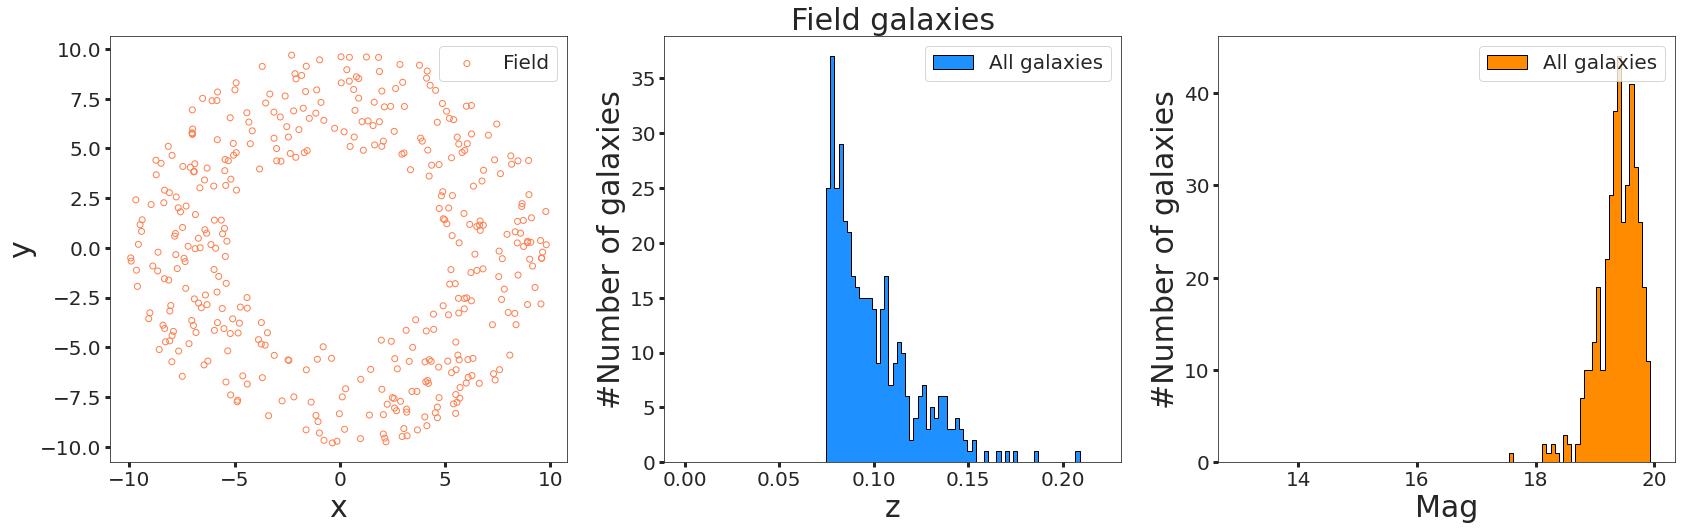

In [139]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
ax1.scatter(ra[mask_field], dec[mask_field], marker='o', color='coral', facecolor='none', label="Field")
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)

ax2 = fig.add_subplot(132)
ax2.hist(zml[mask_field], bins=100, color="dodgerblue", histtype="stepfilled", edgecolor="black", range=[0, 0.22], label="All galaxies")
ax2.set_xlabel('z',fontsize=fontsize)
ax2.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)

ax2.set_title("Field galaxies", fontsize=fontsize)

ax3 = fig.add_subplot(133)
ax3.hist(rpetro[mask_field], bins=100, color="darkorange", histtype="stepfilled", edgecolor="black", range=[13, 20], label="All galaxies")
ax3.set_xlabel('Mag',fontsize=fontsize)
ax3.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.legend(fontsize=labelsize)

fig.tight_layout(pad=3.0)

In [145]:
#compute the density of field galaxies by summing up all galaxies we "know" are in the field and dividing the volume of the cylinder under consideration

Rlim = 10
zlim = 0.2
zmin = zagl + 5*sigma_z #zmin is the cut in redshift we assumed between cluster and field 

volume_field = np.pi * (zlim - zmin) * (Rlim**2 - Ragl**2)
n_F = np.sum(mask_field) / volume_field

In [146]:
N_F = n_F * np.pi * Rmax**2 * zmin
print("Number of field galaxies in the region of the cluster by computing first the density n_F: {:.2f}".format(N_F))

Number of field galaxies in the region of the cluster by computing first the density n_F: 82.56


In [147]:
sep2 = clustercentric_distance(xcampo_r, ycampo_r)

mask_field_in_cluster = (sep2 < Rmax) & (zcampo_r < (zagl + 5*sigma_z))

print("Number of field galaxies that are actually in the cluster region: {:.2f}".format(np.sum(mask_field_in_cluster)))

Number of field galaxies that are actually in the cluster region: 84.00


#### Now that we have an "independent" way of calculating $N_F$, we can use it and calculate the prior $P(g \in F) = \frac{N_F}{N_{tot}}$ and $P(g \in G) = 1 - P(g \in F)$

In [149]:
mask_tot = (sep < Rmax) & (zml < (zagl + 5*sigma_z))
N_tot = np.sum(mask_tot)
print("Total number of galaxies in the region of the cluster: {:.2f}".format(N_tot))

Total number of galaxies in the region of the cluster: 384.00


In [151]:
P_ginF = N_F / N_tot
print("Prior P(g in F): {:.2f}".format(P_ginF))

Prior P(g in F): 0.22


In [152]:
P_ginG = 1 - P_ginF
print("Prior P(g in G): {:.2f}".format(P_ginG))

Prior P(g in G): 0.78


#### Next, we have to calculate $\mathcal{P}(P(z) | G)$ and $\mathcal{P}(P(z) | F)$:

$$
\mathcal{P}(P(z) | G) = \int_{z_G - 3 \sigma_z}^{z_G + 3 \sigma_z} \mathcal{P}(z) \mathcal{N}(z_G, \sigma_z) dz
$$

$$
\mathcal{P}(P(z) | F) = \int_{z_G - 3 \sigma_z}^{z_G + 3 \sigma_z} \frac{\mathcal{P}(z)}{\mathcal{w}(\sigma_z)}
$$

In [20]:
# Calc_PDF_series
def calc_PDF_series(weights, means, stds, x_range=None, optimize_zml=False):
    '''
    Returns a list of PDFs calculated as a combination of Gaussian functions

    Keyword arguments:
    x            -- Photometric redshift range for which the PDF should be calculated
    weights      -- Weight of the Gaussian components
    means        -- means of the Gaussian components
    stds         -- Standard deviation of the Gaussian components
    optimize_zml -- If the single-point estimate of photometric redshift should be optimized (if True, it will be
                    determined on a finer grid of points)
    '''
    
    if x_range is None:
        x = np.arange(-0.005, 1+0.001, 0.001) 
    else:
        x = x_range
                      
    # Convert columns from string to lists
    if type(weights) != np.ndarray:
        weights = np.array(weights)
        means   = np.array(means)
        stds    = np.array(stds)

    # Calculating PDFs and optimizing photo-zs (optional)
    PDFs           = []
    optimized_zmls = np.empty(len(means))
    
    if np.ndim(weights) == 2: # weights, means, and stds are 2D arrays 
        for i in range(len(weights)):
            PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            PDF = PDF/np.trapz(PDF, x)
            PDFs.append(PDF)
        zmls = x[np.argmax(PDFs, axis=1)]
        
    if np.ndim(weights) == 1:
        PDF  = np.sum(weights*(1/(stds*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((x[:,None]-means)**2)/(stds)**2), axis=1)
        PDFs = PDF/np.trapz(PDF, x)
        zmls = x[np.argmax(PDFs)]

    if optimize_zml == True:
        for i in range(len(weights)):
            # First run
            optimized_x   = np.linspace(zmls[i]-0.002, zmls[i]+0.002, 500, endpoint=True)
            optimized_PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((optimized_x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            optimized_zml = optimized_x[np.argmax(optimized_PDF)]

            # Second run
            optimized_x   = np.linspace(optimized_zml-0.001, optimized_zml+0.001, 300, endpoint=True)
            optimized_PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((optimized_x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            optimized_zmls[i] = optimized_x[np.argmax(optimized_PDF)]

        zmls = optimized_zmls
                
    return PDFs, zmls, x

In [154]:
#The ideia here was to create a PDF for the galaxies based on a set of "weights", "means" and "stds" from a test set of objects, but 
#in the mock the galaxies already have a pre-defined "mean", which is their redshifts, so this idea would not make sense.

photozs_pdfs_table = pd.read_csv("photoz-pdfs-test.csv", usecols=["pdf_weights_0", "pdf_weights_1", "pdf_weights_2", "pdf_weights_3", 
                    "pdf_weights_4", "pdf_weights_5", "pdf_weights_6", "pdf_means_0", "pdf_means_1", "pdf_means_2", "pdf_means_3", "pdf_means_4", 
                    "pdf_means_5", "pdf_means_6", "pdf_stds_0", "pdf_stds_1", "pdf_stds_2", "pdf_stds_3", "pdf_stds_4", "pdf_stds_5", "pdf_stds_6"])

weights_0 = photozs_pdfs_table["pdf_weights_0"]
weights_1 = photozs_pdfs_table["pdf_weights_1"]
weights_2 = photozs_pdfs_table["pdf_weights_2"]
weights_3 = photozs_pdfs_table["pdf_weights_3"]
weights_4 = photozs_pdfs_table["pdf_weights_4"]
weights_5 = photozs_pdfs_table["pdf_weights_5"]
weights_6 = photozs_pdfs_table["pdf_weights_6"]

means_0 = photozs_pdfs_table["pdf_means_0"]
means_1 = photozs_pdfs_table["pdf_means_1"]
means_2 = photozs_pdfs_table["pdf_means_2"]
means_3 = photozs_pdfs_table["pdf_means_3"]
means_4 = photozs_pdfs_table["pdf_means_4"]
means_5 = photozs_pdfs_table["pdf_means_5"]
means_6 = photozs_pdfs_table["pdf_means_6"]

stds_0 = photozs_pdfs_table["pdf_stds_0"]
stds_1 = photozs_pdfs_table["pdf_stds_1"]
stds_2 = photozs_pdfs_table["pdf_stds_2"]
stds_3 = photozs_pdfs_table["pdf_stds_3"]
stds_4 = photozs_pdfs_table["pdf_stds_4"]
stds_5 = photozs_pdfs_table["pdf_stds_5"]
stds_6 = photozs_pdfs_table["pdf_stds_6"]

n = 1300
weights = []
means = []
stds = []

for i in range(n):
    j = np.random.randint(low=0, high=100000)
    weights.append(np.array([weights_0[j], weights_1[j], weights_2[j], weights_3[j], weights_4[j], weights_5[j], weights_6[j]]))
    means.append(np.array([means_0[j], means_1[j], means_2[j], means_3[j], means_4[j], means_5[j], means_6[j]]))
    stds.append(np.array([stds_0[j], stds_1[j], stds_2[j], stds_3[j], stds_4[j], stds_5[j], stds_6[j]]))
    
pdfs, zmls, x = calc_PDF_series(weights, means, stds)

plt.plot(x, PDFs[10])

[ 1.76886212e-04 -8.07438409e-03  1.23970821e-01 -6.33901493e-01]


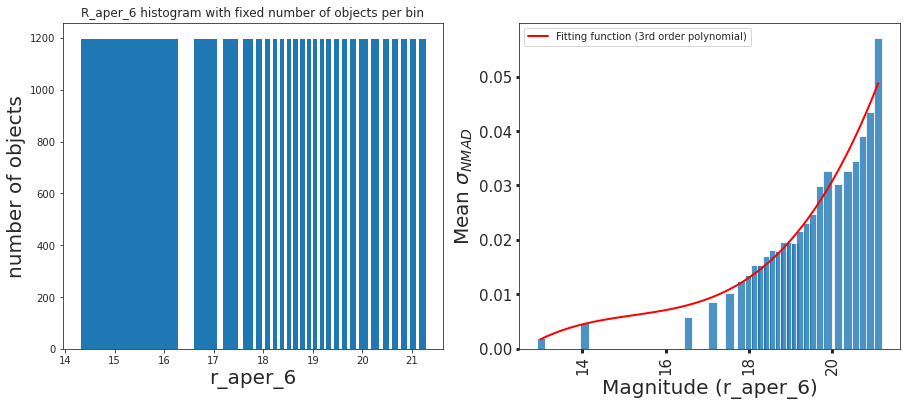

In [11]:
#Estimate sigma_nmad
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))


training_set = pd.read_csv("../CHANCES-target-selection/Results_DF.csv", usecols=['r_aper_6', 'zml', 'z'])

rmag_train = training_set["r_aper_6"]
zml_train = training_set["zml"]
z_train = training_set["z"]


fontsize=20
labelsize=15
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)

n, bins, patches = ax1.hist(rmag_train, histedges_equalN(rmag_train, 25), histtype='bar', rwidth=0.8)
ax1.set_xlabel("r_aper_6", fontsize=fontsize)
ax1.set_ylabel("number of objects", fontsize=fontsize)
ax1.set_title("R_aper_6 histogram with fixed number of objects per bin", fontsize=fontsize*0.6)


mag = np.array(bins)
sigma_nmad = []
mag_bins = []

for i in range(1, len(mag), 1):
    mask_i = (rmag_train > mag[i-1]) & (rmag_train < mag[i])
    delta_z_i = zml_train[mask_i] - z_train[mask_i]
    sigma_nmad.append(np.abs(1.48 * np.median(abs(delta_z_i - np.median(delta_z_i)) / (1 + z_train[mask_i]))))
    mag_bins.append("{:.3f} <= r_mag <= {:.3f}".format(mag[i-1], mag[i]))

    
def func1(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

sigma_nmad_new = np.concatenate((np.array([2e-3]), sigma_nmad))
mag_new = np.concatenate((np.array([13.00]), mag))

xdata = mag_new[:-1]
ydata = sigma_nmad_new

popt1, pcov1 = curve_fit(func1, xdata, ydata)
print(popt1)

ax2 = fig.add_subplot(122)

xnew = np.linspace(xdata[0], xdata[-1], 100)
# ax.scatter(xdata, ydata)
ax2.bar(mag_new[:-1], sigma_nmad_new, alpha=0.8, width=0.2)
ax2.plot(xnew, func1(xnew, *popt1), linewidth=2.0, color='red', label="Fitting function (3rd order polynomial)")
ax2.set_xlabel("Magnitude (r_aper_6)", fontsize=fontsize)
ax2.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, rotation=90)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3)
ax2.legend()
    

def sigma_nmad(r):
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
    return sigma_nmad

In [295]:
def P_pz(i, zagl):
    
    z = zml[i]
    sigma = sigma_nmad(rpetro[i])

    #The ideia here is to normalize both the PDF and the Gaussian representing the cluster  
    def pdf(x, z, sigma):
        y = lambda x, z, sigma: (1 / sigma * np.sqrt(2* np.pi)) * np.exp(-(x - z)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(z, sigma))[0]
        return a * y(x, z, sigma)
        
    
    def gaussian(x, zagl, sigma):
        y = lambda x, zagl, sigma: (1 / sigma * np.sqrt(2* np.pi)) * np.exp(-(x - zagl)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zagl, sigma))[0]
        return a * y(x, zagl, sigma)
    
     
    if zagl - 3*sigma <= 0:
        P_pz_G = integrate.quad(lambda x, z, sigma, zagl: pdf(x, z, sigma) * gaussian(x, zagl, sigma), 0.0, zagl + 3*sigma, args=(z, sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, z, sigma: pdf(x, z, sigma) / (6*sigma), 0.0, zagl + 3*sigma, args=(z, sigma))[0]
        
    if zagl - 3*sigma > 0:
        P_pz_G = integrate.quad(lambda x, z, sigma, zagl: pdf(x, z, sigma) * gaussian(x, zagl, sigma), zagl - 3*sigma, zagl + 3*sigma, args=(z, sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, z, sigma: pdf(x, z, sigma) / (6*sigma), zagl - 3*sigma, zagl + 3*sigma, args=(z, sigma))[0]
        
    return P_pz_G, P_pz_F

In [297]:
Pmem = np.zeros(len(zml))
for i in range(len(zml)):  
    P_pz_G_i, P_pz_F_i = P_pz(i, zagl)
    Pmem[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'True cluster/field separation')

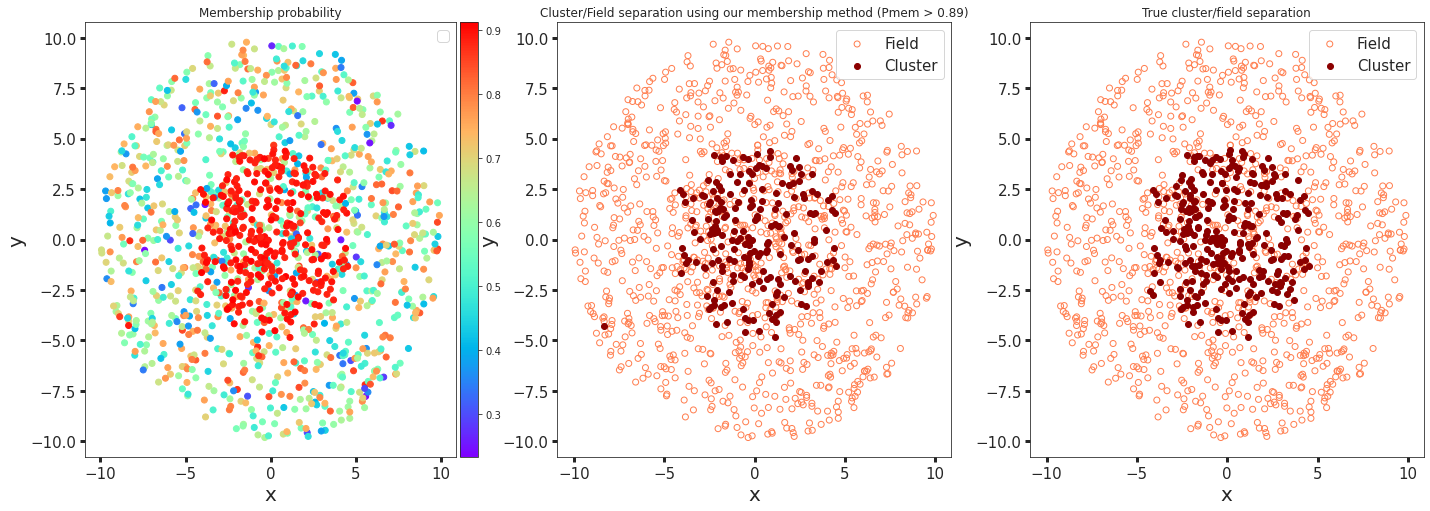

In [367]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
sc1 = ax1.scatter(ra, dec, marker='o', c=Pmem, cmap=cm2, facecolor='none')
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)
ax1.set_title("Membership probability")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc1, cax=cax1, orientation='vertical')


crit = 0.885
ax2 = fig.add_subplot(132)
ax2.scatter(ra[Pmem < crit], dec[Pmem < crit], marker='o', color='coral', facecolor='none', label='Field')
ax2.scatter(ra[Pmem > crit], dec[Pmem > crit], marker='o', color='darkred', label='Cluster')
ax2.set_xlabel('x',fontsize=fontsize)
ax2.set_ylabel('y',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)
ax2.set_title("Cluster/Field separation using our membership method (Pmem > {:.2f})".format(crit))


ax3 = fig.add_subplot(133)
ax3.scatter(ra[:1000], dec[:1000], marker='o', color='coral', facecolor='none', label="Field")
ax3.scatter(ra[1000:], dec[1000:], marker= 'o',color='darkred', label="Cluster")
ax3.set_xlabel('x',fontsize=fontsize)
ax3.set_ylabel('y',fontsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.legend(fontsize=labelsize)
ax3.set_title("True cluster/field separation")

### Compute purity and completeness of the selection

In [373]:
completeness = []
purity = []
d = 0.01
crit = np.arange(0.5, 0.9, d)

for c in crit:
    completeness.append(np.sum((Pmem > c)[1000:]) / len(Pmem[1000:]))
    purity.append(np.sum((Pmem > c)[1000:]) / np.sum(Pmem > c))

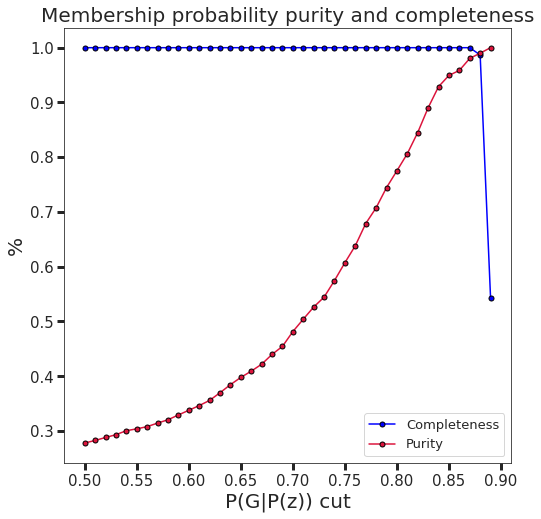

In [374]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

ms = 5
ax1.plot(crit, completeness, marker='o', color="blue", markerfacecolor="blue", label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(crit, purity, marker='o', color="crimson", markerfacecolor="crimson", label="Purity", markersize=ms, markeredgecolor="black")

ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=7)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=7)

ax1.set_ylabel("%", fontsize=fontsize)
ax1.set_xlabel("P(G|P(z)) cut", fontsize=fontsize)
ax1.set_title("Membership probability purity and completeness", fontsize=fontsize)
ax1.legend(fontsize=13)

### Apply the method to Hydra

In [3]:
table = pd.read_csv("../CHANCES-target-selection/tables-photometric/Hydra-InSPLUS-AndLegacy-CHANCES.csv", 
                    usecols=["RA_J2000", "Dec_J2000", "pdf_means", "pdf_weights", "pdf_stds", "r_petro", "zml"])

In [4]:
ra_hydra = np.array(table["RA_J2000"])
dec_hydra = np.array(table["Dec_J2000"])
means_hydra = np.array(table["pdf_means"])
weights_hydra = np.array(table["pdf_weights"])
stds_hydra = np.array(table["pdf_stds"])
rpetro_hydra = np.array(table["r_petro"])
zml_hydra = np.array(table["zml"])

In [5]:
#Defining the center of Hydra (in degress)
ra0 = 159.17
dec0 = -27.524

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
radius = 1.5744

#Redshift of Hydra
zagl_hydra = 0.012

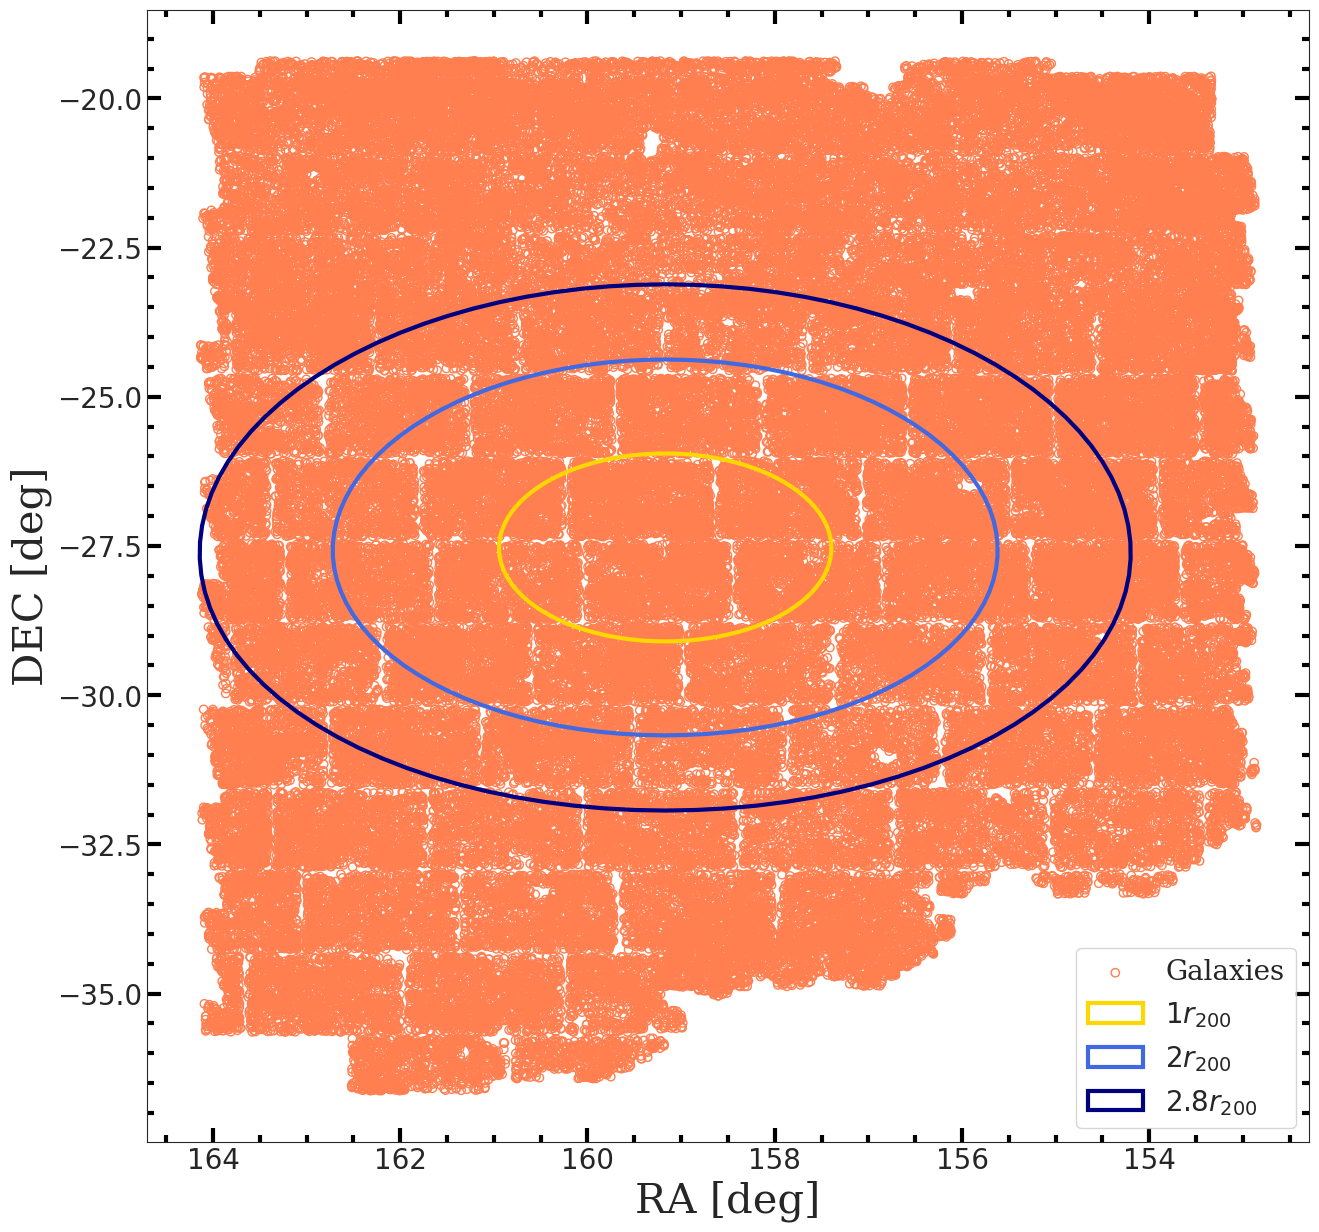

In [25]:
fig = plt.figure(figsize=(15, 15), dpi=100)
ax1 = fig.add_subplot(111)
ax1.scatter(ra_hydra, dec_hydra, marker='o', color='coral', facecolor='none', label="Galaxies")
ax1.set_xlabel('RA [deg]',fontsize=fontsize, family='serif')
ax1.set_ylabel('DEC [deg]',fontsize=fontsize, family='serif')

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
b1 = SphericalCircle(c0, radius*u.deg, resolution=100, vertex_unit='deg', lw=3, label=r'$1 r_{200}$', edgecolor="gold", facecolor="None")
b2 = SphericalCircle(c0, 2*radius*u.deg, resolution=100, vertex_unit='deg', lw=3, label=r'$2 r_{200}$', edgecolor="royalblue", facecolor="None")
b3 = SphericalCircle(c0, 2.8*radius*u.deg, resolution=100, vertex_unit='deg', lw=3, label=r'$2.8 r_{200}$', edgecolor="navy", facecolor="None")
ax1.add_patch(b1)
ax1.add_patch(b2)
ax1.add_patch(b3)

ax1.legend(fontsize=labelsize, prop={'size':labelsize,'family':'serif'})

ax1.invert_xaxis()

tick_color = 'black'
ax1.xaxis.set_tick_params(which='both',labelsize=20,direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax1.yaxis.set_tick_params(which='both',labelsize=20,direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=3, length=5)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax1.minorticks_on()

plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/Hydra_Ra_DEC_circles.pdf", dpi='figure', format='pdf')

In [12]:
#Calculate sigma_nmad for each galaxy, as a function of magnitude
sigma_z = np.array([sigma_nmad(r) for r in rpetro_hydra])

In [13]:
#Calculate separation of the galaxies to the center of the Cluster
sep_hydra = clustercentric_distance(ra_hydra, dec_hydra, ra0, dec0)

In [14]:
#Create a mask to select candidate field galaxies
Rlim = 2.8*radius
Ragl = 2.0*radius
f = 1.5

mask_field = (sep_hydra > Ragl) & (sep_hydra < Rlim) & ((zml_hydra < (zagl_hydra - f*sigma_z)) | (zml_hydra > (zagl_hydra + f*sigma_z)))

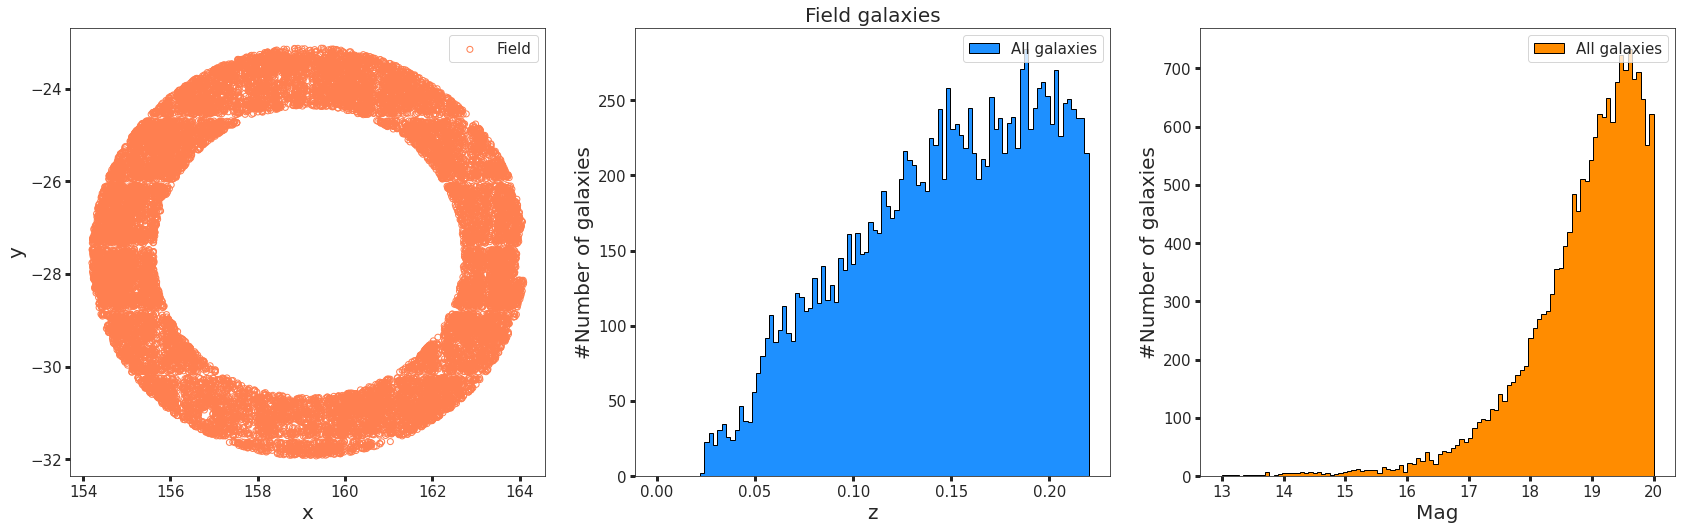

In [15]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
ax1.scatter(ra_hydra[mask_field], dec_hydra[mask_field], marker='o', color='coral', facecolor='none', label="Field")
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)

ax2 = fig.add_subplot(132)
ax2.hist(zml_hydra[mask_field], bins=100, color="dodgerblue", histtype="stepfilled", edgecolor="black", range=[0, 0.22], label="All galaxies")
ax2.set_xlabel('z',fontsize=fontsize)
ax2.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)

ax2.set_title("Field galaxies", fontsize=fontsize)

ax3 = fig.add_subplot(133)
ax3.hist(rpetro_hydra[mask_field], bins=100, color="darkorange", histtype="stepfilled", edgecolor="black", range=[13, 20], label="All galaxies")
ax3.set_xlabel('Mag',fontsize=fontsize)
ax3.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.legend(fontsize=labelsize)

fig.tight_layout(pad=3.0)

In [463]:
#Calculating the field galaxy number density
zlim = zml_hydra[mask_field].max()
zmin = zml_hydra[mask_field].min()

volume_field = np.pi * (zlim - zmin) * (Rlim**2 - Ragl**2)
n_F = np.sum(mask_field) / volume_field

In [464]:
N_F = n_F * np.pi * Ragl**2 * zmin
print("Number of field galaxies in the region of the cluster by computing first the density n_F: {:.2f}".format(N_F))

Number of field galaxies in the region of the cluster by computing first the density n_F: 2461.00


In [465]:
mask_tot = (sep_hydra < Ragl) & (zml_hydra < (zagl + 5*sigma_z))
N_tot = np.sum(mask_tot)
print("Total number of galaxies in the region of the cluster: {:.2f}".format(N_tot))

P_ginF = N_F / N_tot
print("Prior P(g in F): {:.2f}".format(P_ginF))

P_ginG = 1 - P_ginF
print("Prior P(g in G): {:.2f}".format(P_ginG))

Total number of galaxies in the region of the cluster: 2528.00
Prior P(g in F): 0.97
Prior P(g in G): 0.03


#### I think we will need a better approach to calculate the background density of galaxies in the case of the real cluster, maybe using a larger area or something. For now, let's use the values we got from the mock

In [16]:
P_ginF = 0.22
P_ginG = 0.78

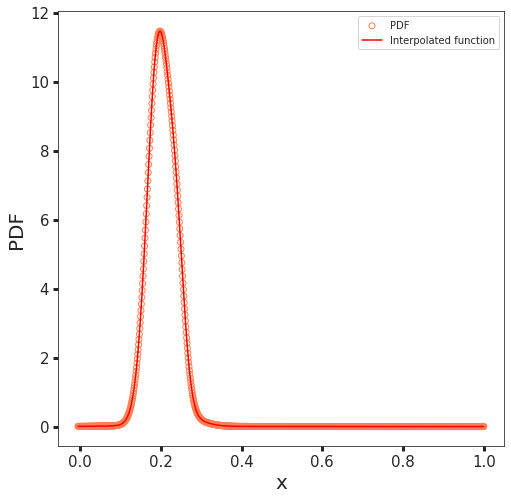

In [45]:
i = 10

sigma = sigma_nmad(rpetro_hydra[i])

means_string = means_hydra[i].split(',')
weights_string = weights_hydra[i].split(',')
stds_string = stds_hydra[i].split(',')

means = np.array([float(_) for _ in means_string])
weights = np.array([float(_) for _ in weights_string])
stds = np.array([float(_) for _ in stds_string])

pdfs, zmls, x = calc_PDF_series(weights, means, stds) 

pdfs_interp = interp1d(x, pdfs)
a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]

pdf_func = lambda x: a * pdfs_interp(x)


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(x, pdfs, marker='o', color='coral', facecolor='none', label="PDF")
ax1.plot(x, pdfs_interp(x), color='red', label="Interpolated function")
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('PDF',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
plt.legend()

In [74]:
def P_pz(i, zagl, means, weights, stds, rmag):

    sigma = sigma_nmad(rmag[i])
    
    means = np.array([float(_) for _ in means[i].split(',')])
    weights = np.array([float(_) for _ in weights[i].split(',')])
    stds = np.array([float(_) for _ in stds[i].split(',')])

    pdfs, zmls, x = calc_PDF_series(weights, means, stds) 
    
    pdfs_interp = interp1d(x, pdfs)
    a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]

    pdf_func = lambda x: a * pdfs_interp(x)
        
    
    def gaussian(x, zagl, sigma):
        y = lambda x, zagl, sigma: (1 / sigma * np.sqrt(2* np.pi)) * np.exp(-(x - zagl)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zagl, sigma))[0]
        return a * y(x, zagl, sigma)
    
     
    if zagl - 3*sigma <= 0:
        P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), 0.0, zagl + 3*sigma, args=(sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), 0.0, zagl + 3*sigma, args=(sigma))[0]
        
    if zagl - 3*sigma > 0:
        P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), zagl - 3*sigma, zagl + 3*sigma, args=(sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), zagl - 3*sigma, zagl + 3*sigma, args=(sigma))[0]
        
    return P_pz_G, P_pz_F

In [53]:
Pmem_hydra = np.zeros(len(zml_hydra))
for i in range(len(zml_hydra)):  
    P_pz_G_i, P_pz_F_i = P_pz(i, zagl_hydra, means_hydra, weights_hydra, stds_hydra, rpetro_hydra)
    Pmem_hydra[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

/tmp/ipykernel_1209392/2182320795.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/tmp/ipykernel_1209392/2182320795.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), 0.0, zagl + 3*sigma, args=(sigma, zagl))[0]
/tmp/ipykernel_1209392/2182320795.py:25: IntegrationWarning: The occurrence of roundoff error is detected, whic

In [193]:
np.save("Pmem_Hydra", Pmem)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


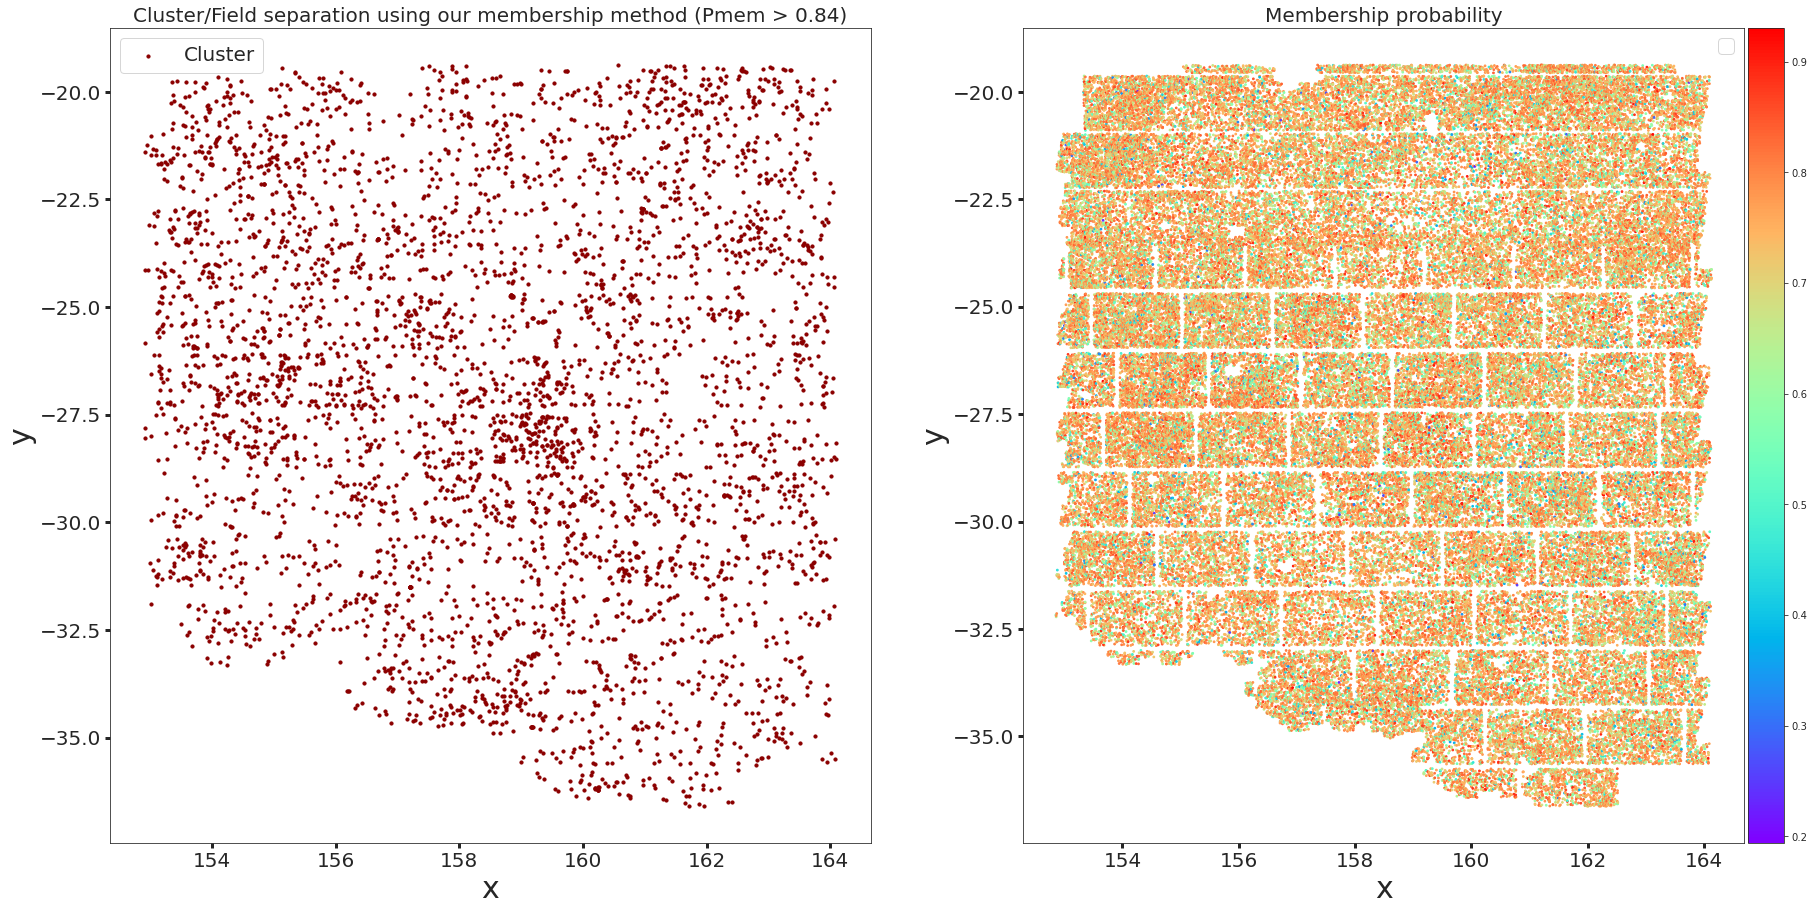

In [166]:
crit = 0.84
ms = 3

fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)
# ax1.scatter(ra_hydra[Pmem < crit], dec_hydra[Pmem < crit], marker='o', color='coral', facecolor='none', s=2, label='Field')
ax1.scatter(ra_hydra[Pmem > crit], dec_hydra[Pmem > crit], marker='o', color='darkred', s=10, label='Cluster')
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.set_title("Cluster/Field separation using our membership method (Pmem > {:.2f})".format(crit), fontsize=labelsize)

ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(ra_hydra, dec_hydra, marker='o', c=Pmem, cmap=cm2, s=ms, facecolor='none')
ax2.set_xlabel('x',fontsize=fontsize)
ax2.set_ylabel('y',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)
ax2.set_title("Membership probability", fontsize=labelsize)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc2, cax=cax2, orientation='vertical')

ax1.legend(fontsize=labelsize)

### Hard to say if this worked or not. But instead we can do it for a catalogue crossmatched with spectroscopic data and compare the result with what we get from applying sigma clipping galaxy membership over the spectroscopic data

In [14]:
table_speczs = pd.read_csv("../CHANCES-target-selection/tables-photometric/Hydra-InSPLUS-AndLegacy-CHANCES-specz_crossmatch.csv", 
                                     usecols=["OBJECT_ID", "RA_J2000", "Dec_J2000", "pdf_means", "pdf_weights", "pdf_stds", "r_petro", "zml", "z"])

In [15]:
objid_specz = np.array(table_speczs["OBJECT_ID"])
ra_specz = np.array(table_speczs["RA_J2000"])
dec_specz = np.array(table_speczs["Dec_J2000"])
means_specz = np.array(table_speczs["pdf_means"])
weights_specz = np.array(table_speczs["pdf_weights"])
stds_specz = np.array(table_speczs["pdf_stds"])
rpetro_specz = np.array(table_speczs["r_petro"])
zml_specz = np.array(table_speczs["zml"])
z_specz = np.array(table_speczs["z"])

In [16]:
#Define a range of redshifts for the cluster
zlower = 0
zupper = 0.03

In [17]:
def sigma_clipping(z_spec, ids, zlower, zupper, sigma):
    '''
    Perform a cluster spectroscopic membership using sigma clipping
    '''
    # It is necessary to restrict a little the sample.  We have to look at this cluster by cluster
    cluster_max_cut = (z_spec > zlower) & (z_spec < zupper)

    cluster_sig = sigma_clip(z_spec[cluster_max_cut], sigma=sigma, cenfunc='median', stdfunc='mad_std') 

    # Objects selected after applying the 3sigmaclipping cut
    specz_members = z_spec[cluster_max_cut][~cluster_sig.mask]
    id_members = ids[cluster_max_cut][~cluster_sig.mask]
    
    return specz_members, id_members

In [18]:
z_members, id_members = sigma_clipping(z_specz, objid_specz, zlower, zupper, 3)
mask_members = np.isin(objid_specz, id_members)

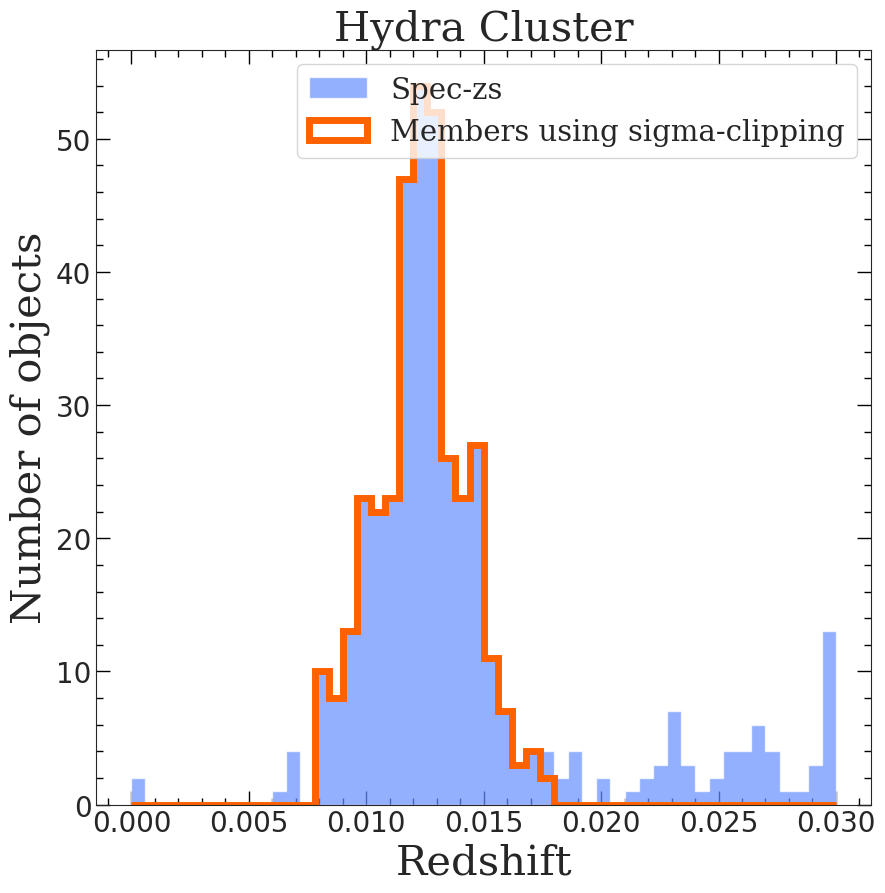

In [19]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)

ax.hist(z_specz, alpha=0.7, label='Spec-zs', bins=50, range=(zlower, zupper), histtype='stepfilled', color=color_bl)
ax.hist(z_members, alpha=1.0, label='Members using sigma-clipping', bins=50, range=(zlower, zupper), histtype='step', lw=5, color=color_or)
ax.set_title('Hydra Cluster', fontsize=fontsize, family = 'serif')
ax.set_xlabel("Redshift", fontsize=fontsize, family = 'serif')
ax.set_ylabel("Number of objects", fontsize=fontsize, family = 'serif')

tick_color = 'black'
ax.xaxis.set_tick_params(which='both', labelsize=20, direction='in', color=tick_color, bottom=True, top=True, left=True, right=True)
ax.yaxis.set_tick_params(which='both', labelsize=20, direction='in', color=tick_color, bottom=True, top=True, left=True, right=True)

plt.tick_params(which='both', width=1.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax.minorticks_on()

lg=plt.legend(loc=0, prop={'size':fontsize*0.7,'family':'serif'})
lg.draw_frame(True)

#### Now we apply our membership procedure to see what we get

In [109]:
Pmem_specz = np.zeros(len(zml_specz))
for i in range(len(zml_specz)):  
    P_pz_G_i, P_pz_F_i = P_pz(i, zagl_hydra, means_specz, weights_specz, stds_specz, rpetro_specz)
    Pmem_specz[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

/tmp/ipykernel_1209392/3874383896.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/tmp/ipykernel_1209392/3874383896.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhap

In [20]:
Pmem_specz = np.load("Pmem_specz.npy")

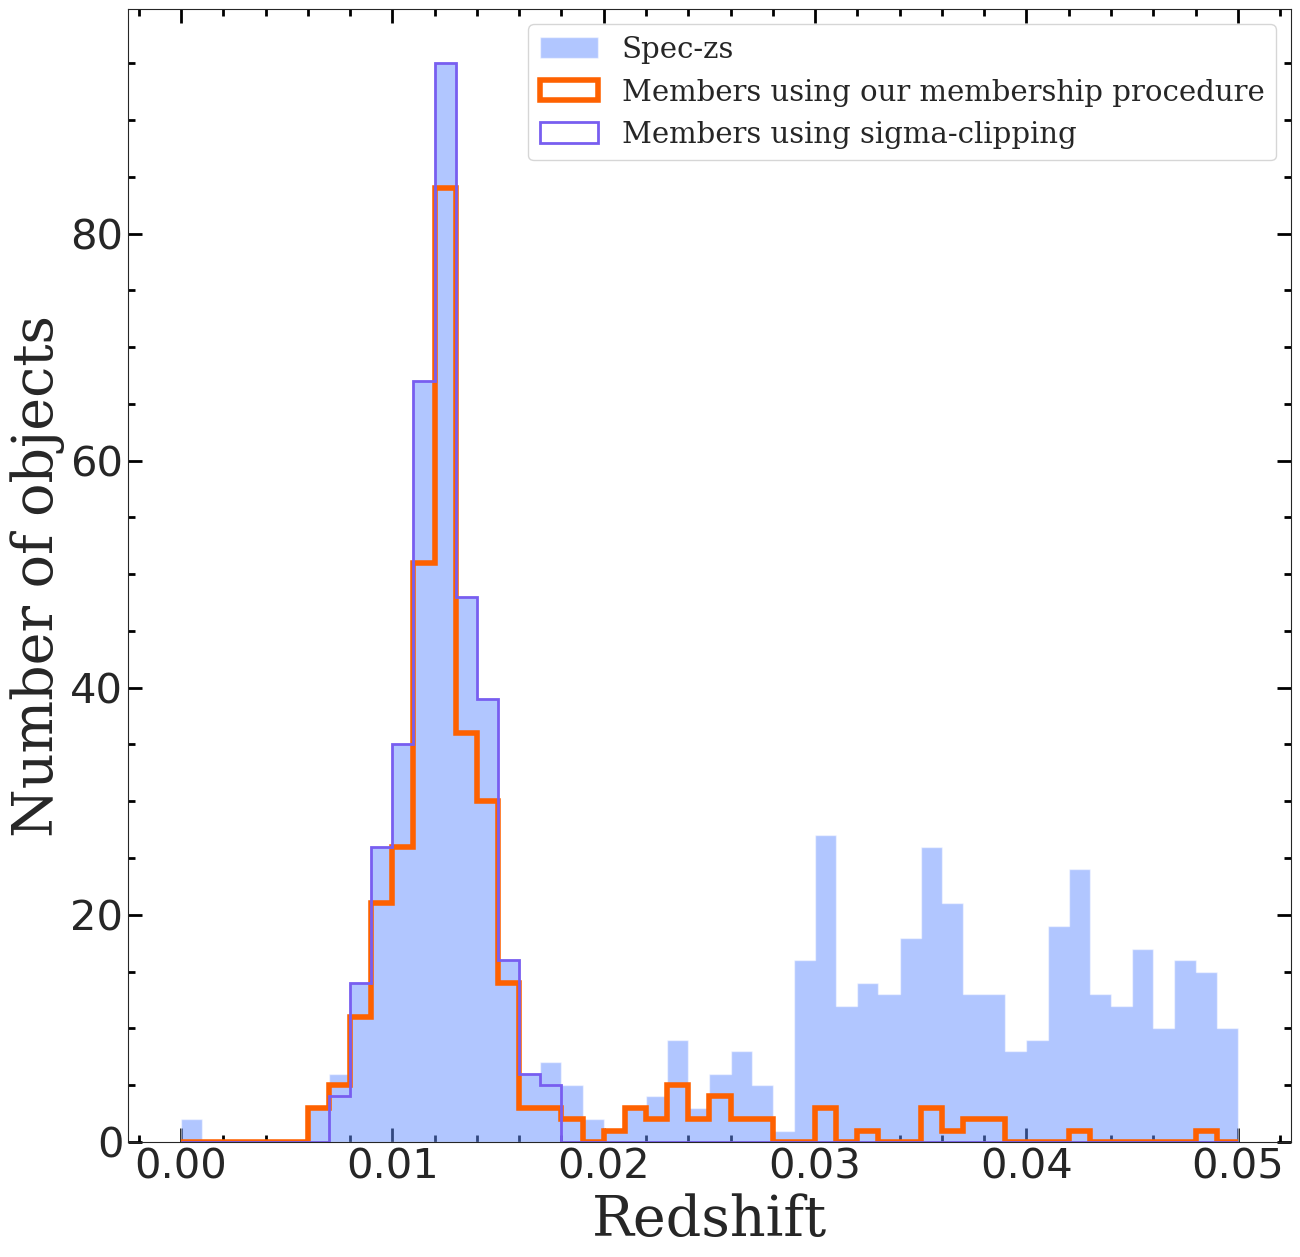

In [50]:
fig = plt.figure(figsize=(15, 15), dpi=100)
ax = fig.add_subplot(111)

ax.hist(z_specz, alpha=0.5, label='Spec-zs', bins=50, range=(0, 0.05), histtype='stepfilled', color=color_bl)
ax.hist(z_specz[Pmem_specz > 0.825], alpha=1.0, label='Members using our membership procedure', bins=50, range=(0, 0.05), histtype='step', lw=4, color=color_or)
ax.hist(z_members, alpha=1.0, label='Members using sigma-clipping', bins=50, range=(0, 0.05), histtype='step', lw=2, color=color_id)
# ax.set_title('Hydra Cluster', fontsize=fontsize, family = 'serif')
ax.set_xlabel("Redshift", fontsize=fontsize, family = 'serif')
ax.set_ylabel("Number of objects", fontsize=fontsize, family = 'serif')

tick_color = 'black'
ax.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.7,'family':'serif'})
lg.draw_frame(True)

plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/specz_distribution_sigma_clipping_membership.pdf", dpi='figure', format='pdf')

In [32]:
completeness = []
purity = []
d = 0.005
crit = np.arange(0.5, 0.9, d)

for c in crit:
    completeness.append(np.sum((Pmem_specz > c) & mask_members) / np.sum(mask_members))
    purity.append(np.sum(mask_members & (Pmem_specz > c)) / np.sum((Pmem_specz > c)))

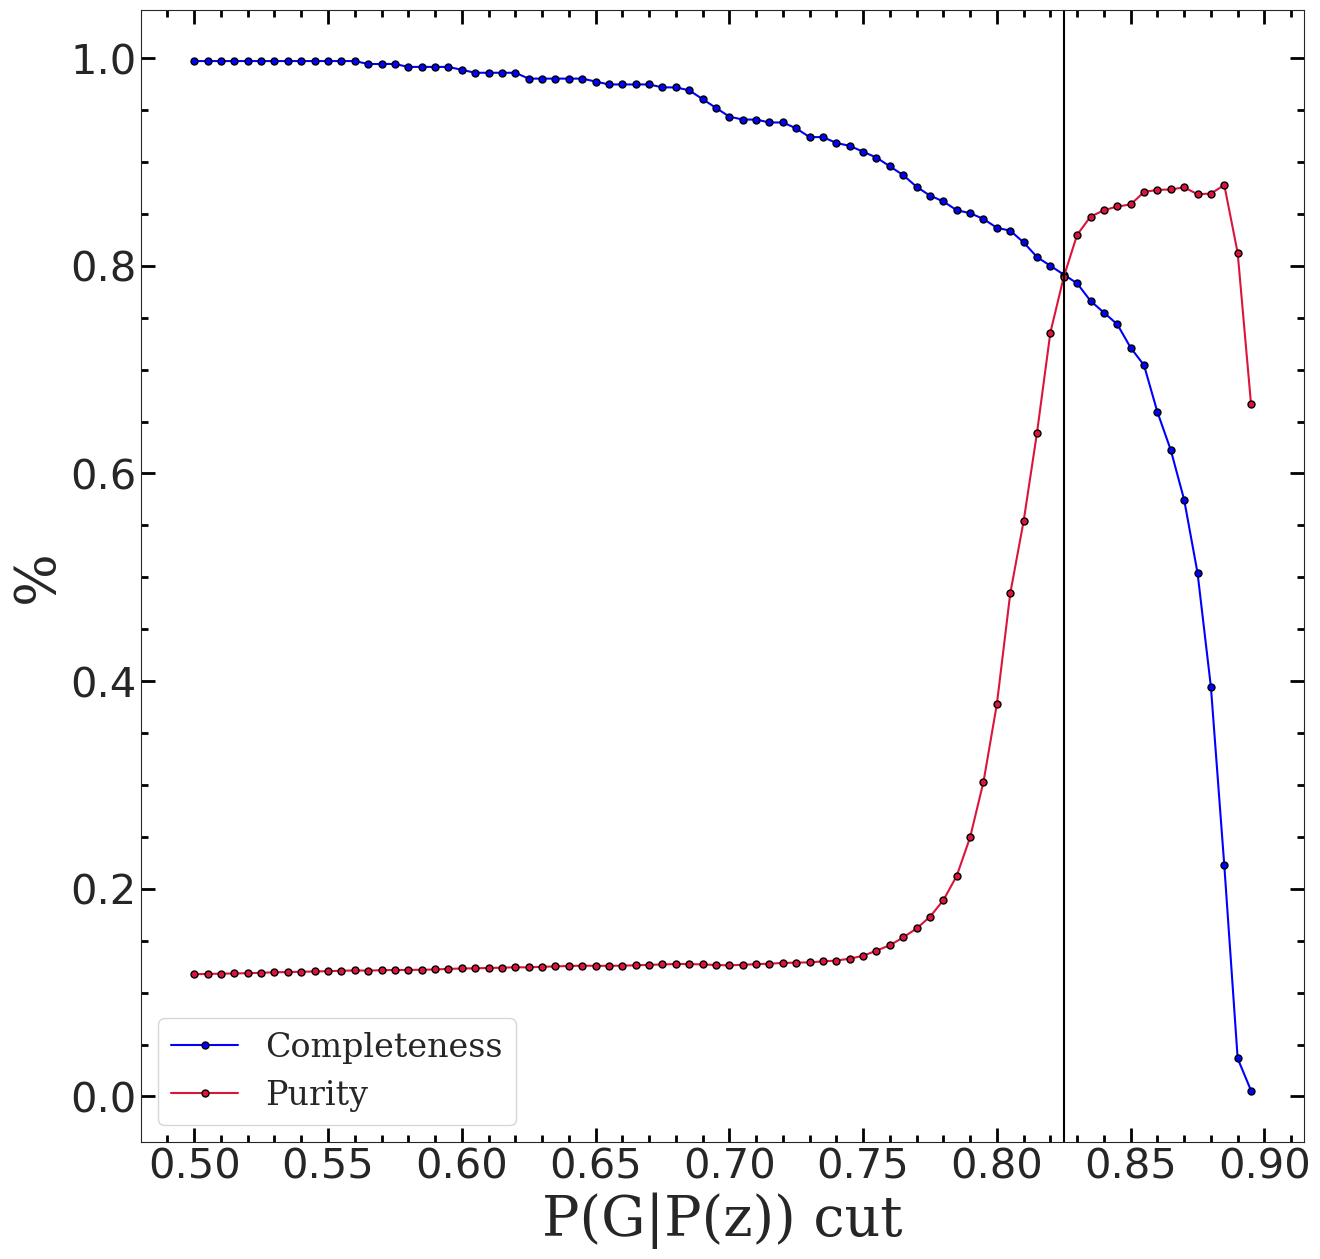

In [51]:
fig = plt.figure(figsize=(15, 15), dpi=100)
ax1 = fig.add_subplot(111)

ms = 5
ax1.plot(crit, completeness, marker='o', color="blue", markerfacecolor="blue", label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(crit, purity, marker='o', color="crimson", markerfacecolor="crimson", label="Purity", markersize=ms, markeredgecolor="black")

# ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=7)
# ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=7)

ax1.set_ylabel("%", fontsize=fontsize, family='serif')
ax1.set_xlabel("P(G|P(z)) cut", fontsize=fontsize, family='serif')
# ax1.set_title("Membership probability purity and completeness", fontsize=fontsize, family='serif')
ax1.legend(fontsize=13)

tick_color = 'black'
ax1.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax1.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax1.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.8,'family':'serif'})
lg.draw_frame(True)

ax1.axvline(0.825, color="black")
plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/membership_probability_purity_completeness_hydra.pdf", dpi='figure', format='pdf')